In [ ]:
# default_exp core

# espiownage core

> Core espiownage parts

In [ ]:
#hide
#from nbdev.showdoc import *
from nbverbose.showdoc import *

In [ ]:
#export 
import cv2
from PIL import Image
import numpy as np
from pathlib import Path
import os
import pandas as pd
from fastai.torch_core import flatten_check
import re
import math
import torch 

## General logging

In [ ]:
#export
#slow
def sysinfo(): 
    "Prints out versions of PyTorch, CUDA, name of GPU and host machine (for logging)"
    try:
        tv, cv = torch.__version__, torch.version.cuda
        tv = re.sub('\+cu.*','',tv)
        TORCH_VERSION = 'torch'+tv[0:-1]+'0'
        CUDA_VERSION = 'cu'+cv.replace('.','')
        print(f"TORCH_VERSION={TORCH_VERSION}; CUDA_VERSION={CUDA_VERSION}")
        print(f"CUDA available = {torch.cuda.is_available()}, Device count = {torch.cuda.device_count()}, Current device = {torch.cuda.current_device()}")
        print(f"Device name = {torch.cuda.get_device_name()}")
    except:
        print("No CUDA info available!  (That's bad)")
    print("hostname:",os.uname()[1])

In [ ]:
#slow
sysinfo()

TORCH_VERSION=torch1.9.0; CUDA_VERSION=cu102
CUDA available = True, Device count = 1, Current device = 0
Device name = NVIDIA GeForce RTX 2070 with Max-Q Design
hostname: oryxpro


## Files and filename manipulation

In [ ]:
#export
def mkdir_if_needed(path:str):
    try:                # go ahead and try to make the the directory
        os.makedirs(path)
    except FileExistsError: pass
    except OSError as exception:
        if exception.errno != errno.EEXIST:  # ignore error if dir already exists
            raise

In [ ]:
#export 
def get_data(dataset_name='cleaner',    # 'cleaner','preclean','spnet','cyclegan','fake'
             force_download=False,      # re-downloads even if you've already got one
             dest_root='~/.espiownage/data', # where the data gets saved
            ):
    "We 'anonymized' our URLs for double-blind review. But this screwed up fastai's downloader so we wrote one"
    assert dataset_name in ['cleaner','preclean','spnet','cyclegan','fake']
    urls = {} 
    urls['cleaner']  = 'https://www.dropbox.com/sh/24eqya4frqg5i7c/AAAVEsRhmc06J_rnFUcId8-ga/data/espiownage-cleaner.tgz'
    urls['preclean'] = 'https://www.dropbox.com/sh/24eqya4frqg5i7c/AADxzcSWr0-5WlZwqM81KNzVa/data/espiownage-preclean.tgz'
    urls['spnet']    = 'https://www.dropbox.com/sh/24eqya4frqg5i7c/AACiVHrATAo6laLsRWvO2dvxa/data/espiownage-spnet.tgz'
    urls['cyclegan'] = 'https://www.dropbox.com/sh/24eqya4frqg5i7c/AABf0H1J4ama2s3WGGFHv3MFa/data/espiownage-cyclegan.tgz'
    urls['fake']     = 'https://www.dropbox.com/sh/24eqya4frqg5i7c/AAAQK6S36pMWkxd-XrXqcf0ma/data/espiownage-fake.tgz'
    data_dir = f'espiownage-{dataset_name}'
    dest_root = os.path.expanduser(dest_root)+'/'
    mkdir_if_needed(dest_root)
    dest = dest_root+data_dir
    if (not os.path.exists(dest)) or (force_download):
        cmd = f"curl -L -o {dest+'.tgz'} {urls[dataset_name]}; tar xfz {dest+'.tgz'} -C {dest_root}"
        print(cmd)
        os.system(cmd)
    return Path(dest_root+data_dir)

In [ ]:
#slow
path = get_data('spnet'); path

Path('/home/sstudent/.espiownage/data/espiownage-spnet')

In [ ]:
#export 
def get_checkpoint(
        model_type='segreg', # 'segreg', 'rings', 'bboxes' . trained on real data only
        force_download=False,  # re-downloads even if you've already got one
        dest_root='~/.espiownage/models', # where the model weights gets saved
        ):
    "For inference: Grab checkpoint of a pretrained espiownage model and return path to its location"
    assert model_type in ['segreg', 'rings', 'bboxes', 'seg']
    urls = {} 
    urls['segreg']  = 'https://www.dropbox.com/s/4dnad92r37ji0ah/seg_reg_full_real_2.pth?dl=0'
    urls['rings'] = 'https://www.dropbox.com/s/awpgvqeonwhjgza/crop-rings-real_k0.pth?dl=0'
    urls['bboxes'] = 'https://www.dropbox.com/s/yiip69zfig7rfob/espi-retinanet-checkpoint-real-k0.pth?dl=0'
    urls['seg'] = 'https://www.dropbox.com/s/woa0gwemio4gami/seg_allone_full_real.pth?dl=0'

    filename = urls[model_type].split('/')[-1].replace('?dl=0','')

    if 'bboxes' == model_type: 
        print("Warning: the IceVision install is incompatible with the fastai version used for the seg-reg and ring counting")
        print("For bounding boxes you (probably) need a dedicated Python environment for that.")

    dest_root = os.path.expanduser(dest_root)+'/'
    mkdir_if_needed(dest_root)
    dest = dest_root+filename
    if (not os.path.exists(dest)) or (force_download):
        cmd = f"curl -L -o {dest} {urls[model_type]}"
        print(cmd)
        os.system(cmd)
        
    return Path(dest)  # return where we saved the checkpoint

In [ ]:
path = get_checkpoint('segreg'); path

curl -L -o /home/sstudent/.espiownage/models/seg_reg_full_real_2.pth https://www.dropbox.com/s/4dnad92r37ji0ah/seg_reg_full_real_2.pth?dl=0


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   148    0   148    0     0    465      0 --:--:-- --:--:-- --:--:--   465
100   318  100   318    0     0    436      0 --:--:-- --:--:-- --:--:--   436
100  1076    0  1076    0     0    614      0 --:--:--  0:00:01 --:--:--  1415
  9  632M    9 61.6M    0     0   214k      0  0:50:16  0:04:54  0:45:22     0

Path('/home/sstudent/.espiownage/models/seg_reg_full_real_2.pth')

In [ ]:
#export 
def meta_to_img_path(
    meta_file:str, # filename of .csv file with annotations
    img_bank='images/',         # alternate location of image files, if not in same dir as meta file
    ):
    '''Suggest the image file that corresponds with an annotation CSV file'''
    meta_file, img_dir = Path(meta_file), Path(os.path.expanduser(img_bank))
    img_file = meta_file.with_suffix('.png')  # check same directory as meta first
    if os.path.exists(img_file): return img_file
    return img_dir / Path(img_file.name)  # return from image storage directory

In [ ]:
meta_to_img_path('annotations/06241902_proc_00023.csv')

Path('images/06241902_proc_00023.png')

In [ ]:
#export 
def meta_to_mask_path(
    meta_file:str, # filename of .csv file with annotations
    mask_dir='masks/',  # output directory; assumed to exist
    ):
    "provides name for segmentation mask file"
    csv_path = Path(meta_file)
    return Path(mask_dir + csv_path.stem+'_P.png')  # _P because that's what CAMVID dataset does  

In [ ]:
meta_to_mask_path('annotations/06241902_proc_00023.csv')

Path('masks/06241902_proc_00023_P.png')

In [ ]:
#export 
def meta_from_str(s):
    "e.g., 06241902_proc_00510_0_45_88_236_1.0 -> 06241902_proc_00510.csv"
    # grab numbers on either side of _proc_
    s = s.split('.')[0]
    splits = s.split('_')
    return splits[0]+'_'+splits[1]+'_'+splits[2]+'.csv'

In [ ]:
assert meta_from_str('06241902_proc_00510_0_45_88_236_1.0.csv') == '06241902_proc_00510.csv'
assert meta_from_str('06241902_proc_00510_0_45_88_236.csv') == '06241902_proc_00510.csv'
assert meta_from_str('06241902_proc_00510.png') == '06241902_proc_00510.csv'

In [ ]:
#export
def combine_file_and_tl_lists(file_list, top_loss_list):
    """for ellipse editor, but adding here: 
    Go through tl list, and if elem e is not in file list, don't copy
    then go through file_list, and if e is already in, don't add"""
    if [] == top_loss_list: return file_list
    new_list = []
    basenames = [os.path.basename(f) for f in file_list]
    fldirname = os.path.dirname(file_list[0])
    meta_top_loss_list = [meta_from_str(x) for x in top_loss_list] # convert from whatever janky name is in tl list
    for e in meta_top_loss_list:
        if e in basenames: new_list.append(fldirname+'/'+e)
    for e in file_list:
        if e not in new_list: new_list.append(e)
    return new_list

In [ ]:
file_list = ['annotations_student/06241902_proc_00000.csv', 'annotations_student/06240907_proc_01001.csv', 'annotations_student/06241902_proc_00004.csv', 'annotations_student/06240907_proc_01756.csv', 'annotations_student/06241902_proc_00009.csv', 'annotations_student/06241902_proc_00013.csv']
top_loss_list = ['06241902_proc_00510_0_45_88_236_1.0', '06240907_proc_01001_0_115_187_322_2.4', '06240907_proc_01197_0_105_185_338_3.33', '06241902_proc_00986_136_73_293_214_2.0', '06241902_proc_01468_0_58_81_211_3.75', '06240907_proc_01756_0_132_158_315_1.3', '06240907_proc_01101_0_101_172_326_4.0']
print("file_list =",file_list)
print("\ntop_lost_list =",top_loss_list)
out = combine_file_and_tl_lists(file_list, top_loss_list)
print("\nout = ",out)

file_list = ['annotations_student/06241902_proc_00000.csv', 'annotations_student/06240907_proc_01001.csv', 'annotations_student/06241902_proc_00004.csv', 'annotations_student/06240907_proc_01756.csv', 'annotations_student/06241902_proc_00009.csv', 'annotations_student/06241902_proc_00013.csv']

top_lost_list = ['06241902_proc_00510_0_45_88_236_1.0', '06240907_proc_01001_0_115_187_322_2.4', '06240907_proc_01197_0_105_185_338_3.33', '06241902_proc_00986_136_73_293_214_2.0', '06241902_proc_01468_0_58_81_211_3.75', '06240907_proc_01756_0_132_158_315_1.3', '06240907_proc_01101_0_101_172_326_4.0']

out =  ['annotations_student/06240907_proc_01001.csv', 'annotations_student/06240907_proc_01756.csv', 'annotations_student/06241902_proc_00000.csv', 'annotations_student/06241902_proc_00004.csv', 'annotations_student/06241902_proc_00009.csv', 'annotations_student/06241902_proc_00013.csv']


In [ ]:
#export 
def meta_to_df(
    meta_file,  # csv file of ellipse data for an image
    ):
    "Reads in an espiownage/SPNet CSV file of ellipse data and returns a Pandas DataFrame"
    col_names = ['cx', 'cy', 'a', 'b', 'angle', 'rings']
    df = pd.read_csv(meta_file, header=None, names=col_names)
    df.drop_duplicates(inplace=True)  # sometimes the data from Zooniverse has duplicate rows
    for index, row in df.iterrows() : # fixup stuff
        [cx, cy, a, b, angle] = [int(round(x)) for x in [row['cx'], row['cy'], row['a'], row['b'], row['angle']]]
        a, b, angle = fix_abangle(a,b,angle)
        row['cx'], row['cy'], row['a'], row['b'], row['angle'] = cx, cy, a, b, angle
    return df

## Ellipses and math

In [ ]:
#export 
def fix_abangle(
    a:float, # semimajor axis
    b:float, # semiminor axis
    angle:float,  # orientation angle in degrees
    ):
    "Makes sure semimajor axis > semiminor axis, and angles are consistent"
    if b > a:
        a, b, angle = b, a, angle+90
    if angle < 0: angle += 180
    elif angle >= 180: angle -= 180
    return a, b, angle

In [ ]:
fix_abangle(5,10,-20)

(10, 5, 70)

In [ ]:
#export 
def draw_ellipse(
    img,         # a cv2 image, *not* a PIL image (similar for grayscale but not RGB)
    center:tuple,      # (cx, cy) tuple
    axes:tuple,        # (a,b) semimajor & minor axes
    angle:float,       # orientation angle in degrees
    color=(0),   # color to draw. tuple or int
    thickness=2, # thickness ofthe lines we draw
    filled=False,  # whether to draw the ellipse as filled or not
    lineType=cv2.LINE_8,  # as opposed to LINE_AA, typically we DON'T want antialiasing for this app 
    startAngle=0, endAngle=360, # arc-angles. should stay at 0 & 360 for full ellipses.
    shift=0, #10,      # shift is for sub-pixel resolution and AA figures. don't need it.
    ):
    """"Draws an ellipse into image.    """
    center = [int(round(x* 2**shift)) for x in center]  
    axes = [int(round(x* 2**shift)) for x in axes]
    if filled: lineType, thickness = cv2.FILLED, -1
    ellipse = cv2.ellipse(
        img, center, axes, -angle,   # -angle because the web interface is "upside down"
        startAngle, endAngle, color,
        thickness, lineType, shift)
    return ellipse

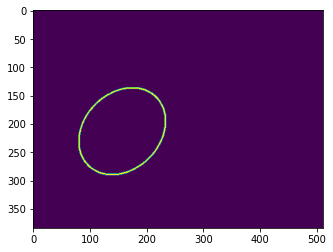

In [ ]:
import matplotlib.pyplot as plt

height, width = 512,384
cx, cy, a, b, angle = 157, 213, 85, 67, 45
img = np.zeros((width, height), dtype=np.uint8)  # numpy w/h is "backwards" to images
img = draw_ellipse(img, (cx,cy), (a,b), angle, color=100, filled=False)
plt.imshow(img)

Let's check what "colors" are in that file, e.g. to make sure there's no anti-aliasing

In [ ]:
print("'colors' =",set(np.array(img).flatten()))

'colors' = {0, 100}


And again, a filled version:

'colors' = {0, 100}


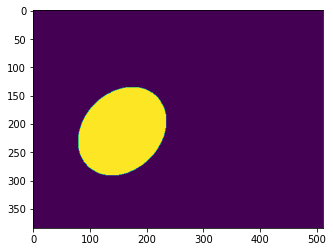

In [ ]:
img = draw_ellipse(img, (cx,cy), (a,b), angle, color=100, filled=True)
print("'colors' =",set(np.array(img).flatten()))
plt.imshow(img)

In [ ]:
#export 
def ellipse_to_bbox(
    cx:float, # x-coordinate of center of ellipse
    cy:float, # y-coordinate of center of ellipse
    a:float,  # semimajor axis
    b:float,  # semiminor axis
    angle_deg:float,  # orientation angle in degrees
    coco=False, # COCO style bbox has last 2 nums as width & height of bbox
    width=512, height=384, # image dimensions for clipping
    clip=True, # clip values at max values of image width & height
    nozero=True,  # Lots of downstream apps hate zero-dimension bounding box. This returns None
    ):
    "converts ellipse to bounding box"
    rad = np.radians(angle_deg)
    a2, b2, cos2, sin2 = [x**2 for x in [a, b, np.cos(rad), np.sin(rad)]]
    delta_x, delta_y = np.sqrt(a2*cos2 + b2*sin2), np.sqrt(a2*sin2 + b2*cos2)
    xmin, xmax = cx - delta_x,  cx + delta_x 
    ymin, ymax = cy - delta_y,  cy + delta_y
    if (xmin > xmax): xmin, xmax = xmax, xmin  # error correction, swap
    if (ymin > ymax): ymin, ymax = ymax, ymin  # swap
    if clip:
        xmin, xmax = np.clip(xmin, 0, width),  np.clip(xmax, 0, width)
        ymin, ymax = np.clip(ymin, 0, height), np.clip(ymax, 0, height)
    if coco: return [round(x, 2) for x in [xmin, ymin, xmax-xmin, ymax-ymin]] # coco is a list, floats are ok
    bbox = int(xmin), int(ymin), int(xmax), int(ymax)
    # Image.crop does not like zero-size dimensions but its error message is cryptic
    if ((xmax-xmin > 0) and (ymax-ymin > 0)) or (not nozero): return bbox
    else: 
        print(f"ellipse_to_bbox: Error: zero-dim bbox = {bbox}. Returning None.")
        return None

bbox =  (80, 136, 233, 289)
'colors' = {0, 50, 100}


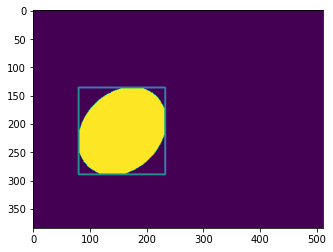

In [ ]:
bb = ellipse_to_bbox(cx, cy, a, b, angle)
print("bbox = ",bb)
img = cv2.rectangle(img, bb[0:2], bb[2:4], color=50, thickness=2)
print("'colors' =",set(np.array(img).flatten()))
plt.imshow(img)

In [ ]:
ellipse_to_bbox(cx, cy, a, b, angle, coco=True)

[80.47, 136.47, 153.06, 153.06]

In [ ]:
ellipse_to_bbox(0, 0, 0, 0, 0)  # check for (graceful handling of) errors

ellipse_to_bbox: Error: zero-dim bbox = (0, 0, 0, 0). Returning None.


In [ ]:
#export 
def ring_float_to_class_int(rings:float, step=0.1):
    """Ring value rounded to classifier value; rounded to nearest step size"""
    return round(rings/step)

In [ ]:
ring_float_to_class_int(10.5, 0.1), ring_float_to_class_int(10.5, 0.2), ring_float_to_class_int(10.5, 1)

(105, 52, 10)

In [ ]:
#export 
def crop_to_bbox(
    img,        # an image (PIL preferred, but will convert from cv2 if neede)
    bbox,       # [xmin, ymin, d3, d4] where d3,d4 are either xmax,ymax (default) or see coco (below)
    coco=False, # COCO style input bbox has last 2 nums as width & height of bbox
    width=512, height=384, # image dimensions for clipping
    clip=True,  # clip values at max values of image width & height
    ):
    "Crops an image to bbox, returns cropped image"
    if isinstance(img,np.ndarray): img = Image.fromarray(img)  # convert cv2 image to PIL
    xmin, ymin = bbox[0], bbox[1]
    if coco: xmax, ymax = bbox[0]+bbox[2], bbox[1]+bbox[3]
    else:    xmax, ymax = bbox[2], bbox[3]
    if clip:
        xmin, xmax = np.clip(xmin, 0, width),  np.clip(xmax, 0, width)
        ymin, ymax = np.clip(ymin, 0, height), np.clip(ymax, 0, height)
    # check ordering 
    if (xmin > xmax): xmin, xmax = xmax, xmin  # error correction, swap
    if (ymin > ymax): ymin, ymax = ymax, ymin  # swap
    crop_bb = (int(xmin), int(ymin), int(xmax), int(ymax))
    
    # Image.crop does not like zero-size dimensions but its error message is cryptic
    if (xmax-xmin > 0) and (ymax-ymin > 0): return img.crop(crop_bb)
    else: 
        print(f"crop_to_bbox: Error: zero-dim crop request, crop_bb = {crop_bb}. Returning None.")
        return None

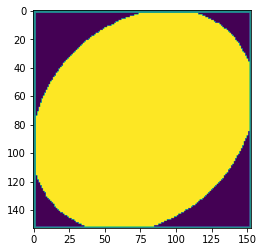

In [ ]:
from matplotlib.pyplot import imshow

imshow(crop_to_bbox(img, bb))

In [ ]:
bb_bad = crop_to_bbox(img, [-100,-100,-10,10])

crop_to_bbox: Error: zero-dim crop request, crop_bb = (0, 0, 0, 10). Returning None.


Hopefully we didn't crop in place and the original full-size image is still there?

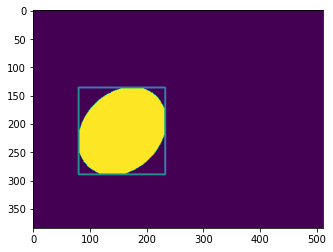

In [ ]:
plt.imshow(img)

In [ ]:
#export 
def is_in_box(
    p,     # a point as a (x,y) coordinate pair 
    bb,    # a bounding box of the form [xmin,ymin,xmax,ymax]
    ):
    "Is this point within that bounding box?"
    x, y = p 
    return (x>=bb[0]) and (x<=bb[2]) and (y>=bb[1]) and (y<=bb[3])

In [ ]:
assert is_in_box((100,100),(10,30,180,50)) == False
assert is_in_box((100,100),(10,30,180,150)) == True

## "Regression accuracy" metric(s)

In [ ]:
#export
def acc_reg(inp, targ, bin_size=1): 
    "Accuracy for regression: Are we within +/- bin_size?"
    inp,targ = flatten_check(inp,targ) # https://docs.fast.ai/metrics.html#flatten_check
    where_correct = (inp-targ).abs() < bin_size
    return where_correct.float().mean() 

Let's test this metric:

In [ ]:
#let's test this metric
a = torch.rand(10)
b = a + torch.rand(10)
print(a)
print(b)
tol = 0.7
print( (a - b).abs() < tol)
print(acc_reg(a,b,bin_size=tol))

tensor([0.7457, 0.7263, 0.3642, 0.8471, 0.4808, 0.5804, 0.6998, 0.9799, 0.4964,
        0.2416])
tensor([0.9151, 1.2286, 0.4012, 1.5131, 0.6677, 1.0552, 1.1226, 1.0571, 1.1422,
        0.6349])
tensor([True, True, True, True, True, True, True, True, True, True])
TensorBase(1.)


We'll use a few predefined intervals:

In [ ]:
#export
def acc_reg05(inp, targ): return acc_reg(inp, targ, bin_size=0.5)

In [ ]:
#export 
def acc_reg07(inp, targ): return acc_reg(inp, targ, bin_size=0.7) 

In [ ]:
#export
def acc_reg1(inp, targ): return acc_reg(inp, targ, bin_size=1)

In [ ]:
#export
def acc_reg15(inp, targ): return acc_reg(inp, targ, bin_size=1.5)

In [ ]:
#export
def acc_reg2(inp, targ): return acc_reg(inp, targ, bin_size=2)

## Workflow utils

In [ ]:
#export
def kfold_split(
    data,         # list of indices or data points to split into train & val
    k,            # where we are in the iteration
    nk = 5         # number of folds
    ):
    "Breaks one list into train & val as per k-fold cross-validation. For use with fastai IndexSplitter (throw out train_list) or IceVision's FixedSplitter"
    n = len(data)
    val_size = int(round(n/nk))
    if k < nk-1: 
        val_list = data[k*val_size:(k+1)*val_size]
        train_list = data[0:k*val_size] + data[(k+1)*val_size:n]
    else:   # last one might be a bit different
        val_list = data[k*val_size:]
        train_list = data[0:-len(val_list)]
    return train_list, val_list 

In [ ]:
data = list(range(10))
nk = 5
for k in range(nk):
    print(kfold_split(data, k))

([2, 3, 4, 5, 6, 7, 8, 9], [0, 1])
([0, 1, 4, 5, 6, 7, 8, 9], [2, 3])
([0, 1, 2, 3, 6, 7, 8, 9], [4, 5])
([0, 1, 2, 3, 4, 5, 8, 9], [6, 7])
([0, 1, 2, 3, 4, 5, 6, 7], [8, 9])
